In [1]:
!pip install ultralytics==8.0.28 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 272.6/272.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.1/309.1 kB 599.3 kB/s eta 0:00:00


In [2]:
import shutil
shutil.rmtree('/content/sample_data')

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="g52GrASCILBnLMBPlLh4")
project = rf.workspace("connor-mclaughlin-qzfru").project("hockey-tfu8w")
version = project.version(1)
dataset = version.download("yolov8")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.28, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to hockey-1 in yolov8:: 100%|██████████| 2378/2378 [00:00<00:00, 8368.71it/s]


Данный датасет содержит картинки хоккейных матчей. В нем 3 класса (судья, игрок и шайба).

In [4]:
from ultralytics import YOLO

In [5]:
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:00<00:00, 155MB/s] 


In [6]:
model.train(data="/content/datasets/data.yaml", epochs=30, optimizer= 'Adam', patience=10, cos_lr=True, lr0=1e-3,
             plots=True)

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8s.yaml, data=/content/datasets/data.yaml, epochs=30, patience=10, batch=16, imgsz=640, save=True, cache=False, device=, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, overlap_mask=True, mask_ratio=4, dropout=False, val=True, save_json=False, save_hybrid=False, conf=0.001, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=ultralytics/assets/, show=False, save_txt=False, save_conf=False, save_crop=False, hide_labels=False, hide_conf=False, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, o

In [7]:
from IPython.display import Image

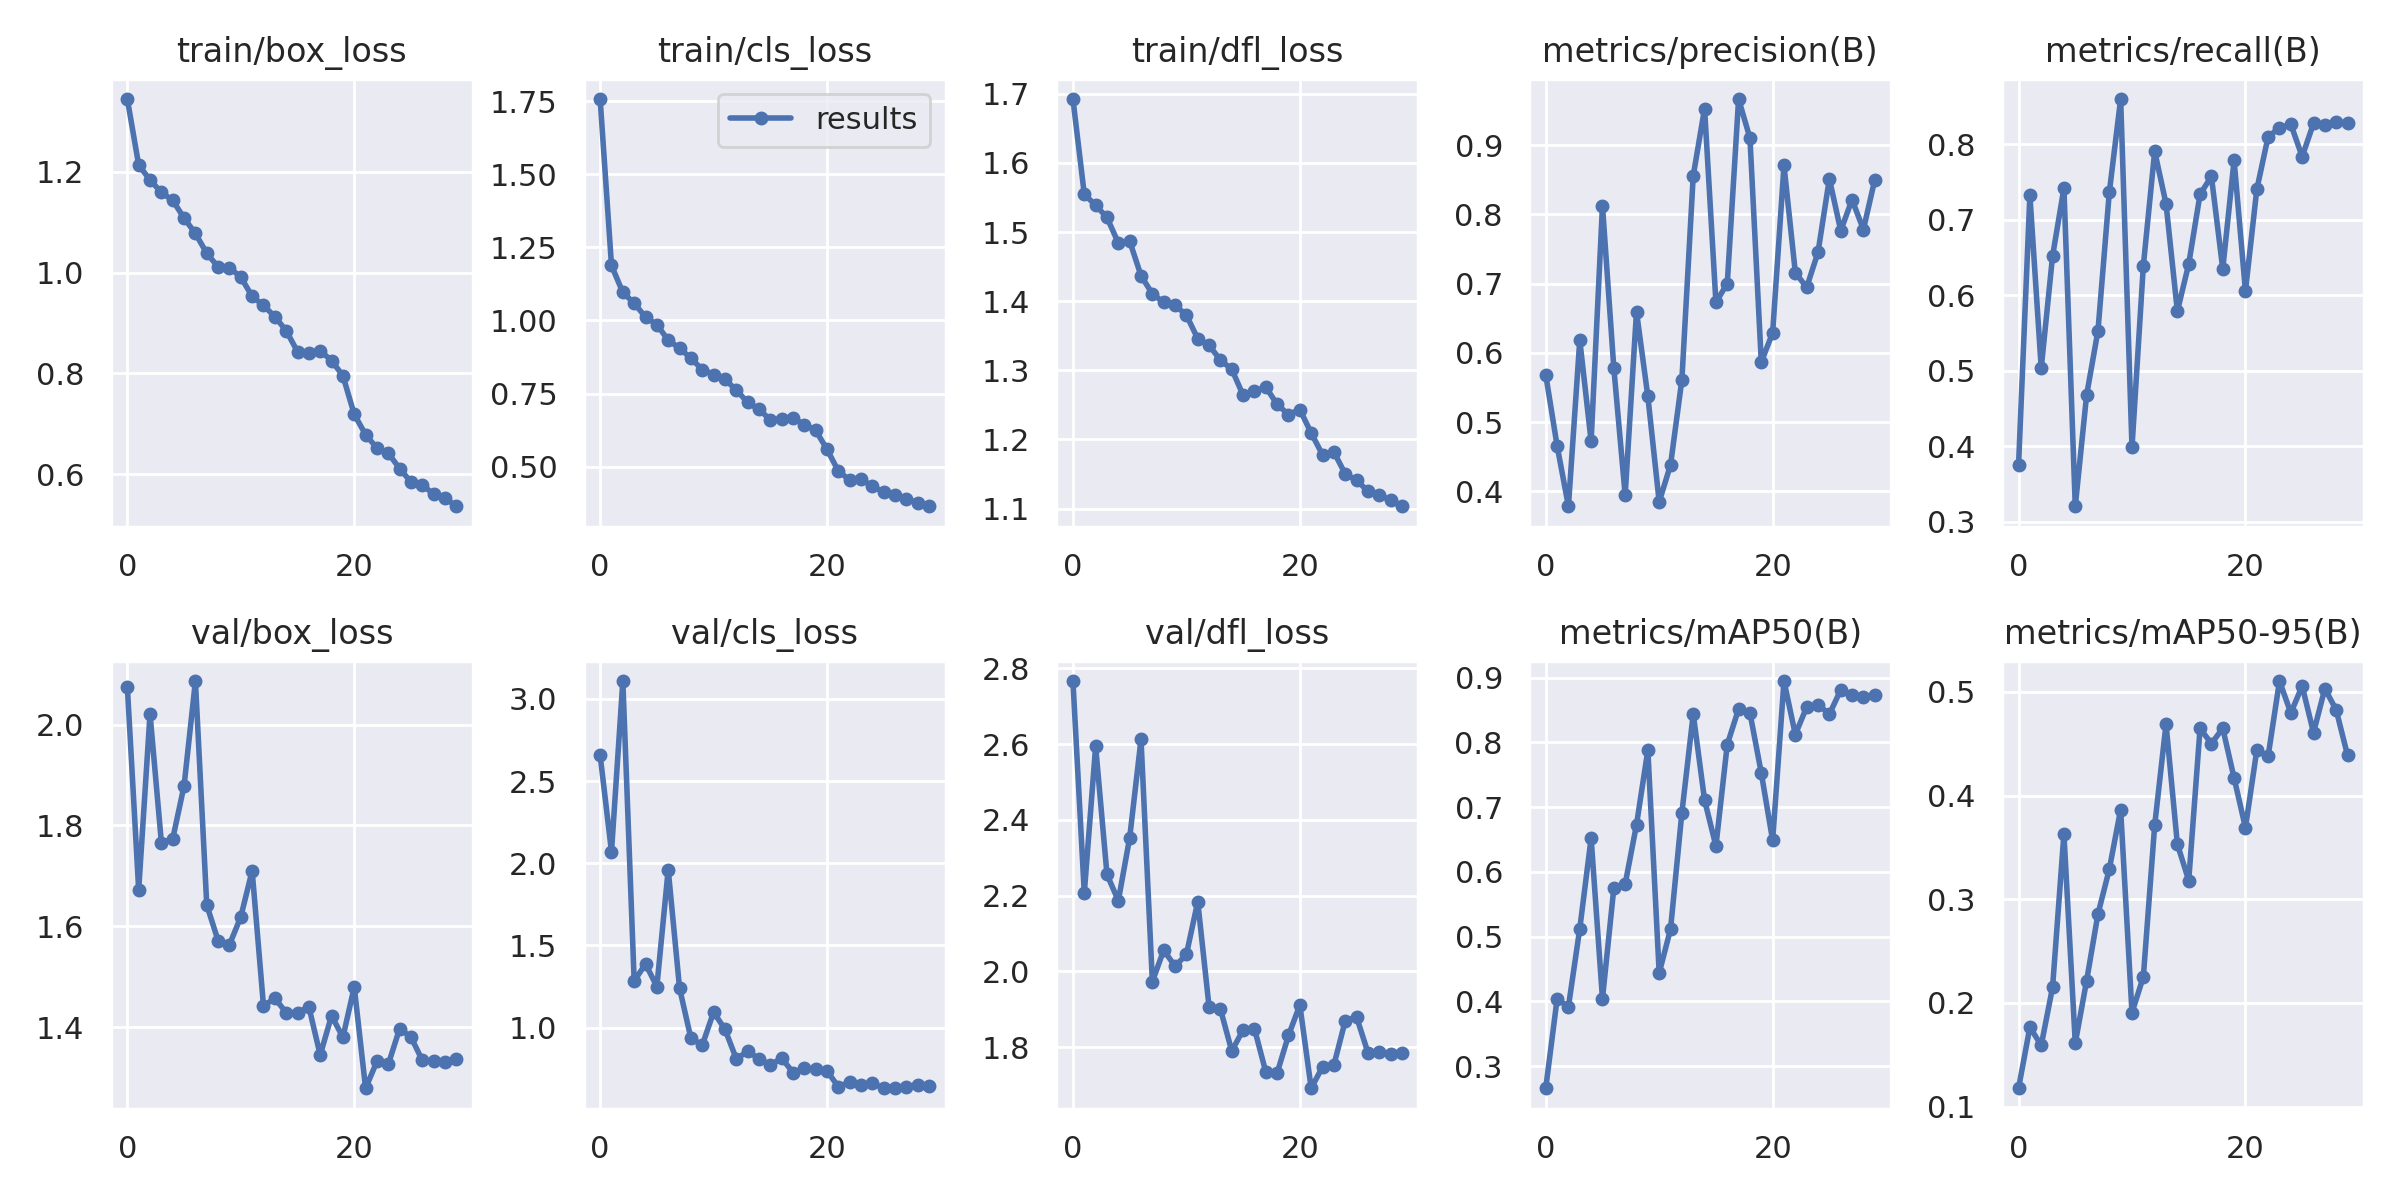

In [8]:
Image('/content/runs/detect/train/results.png')

Пусть и скачкообразно, но заметна тенденция уменьшения ошибок. На валидационной выборки графики не сильно хуже, чем на тренировочной, следовательно переобучения не наблюдается. Кроме того метрика map50 показывает неплохой результат (0.9), хотя метрика map50-90 существенно меньше. Но невысокий показатель некоторых метрик обуславливается недообученностью модели, вследствие нехватки временных и технических ресурсов.

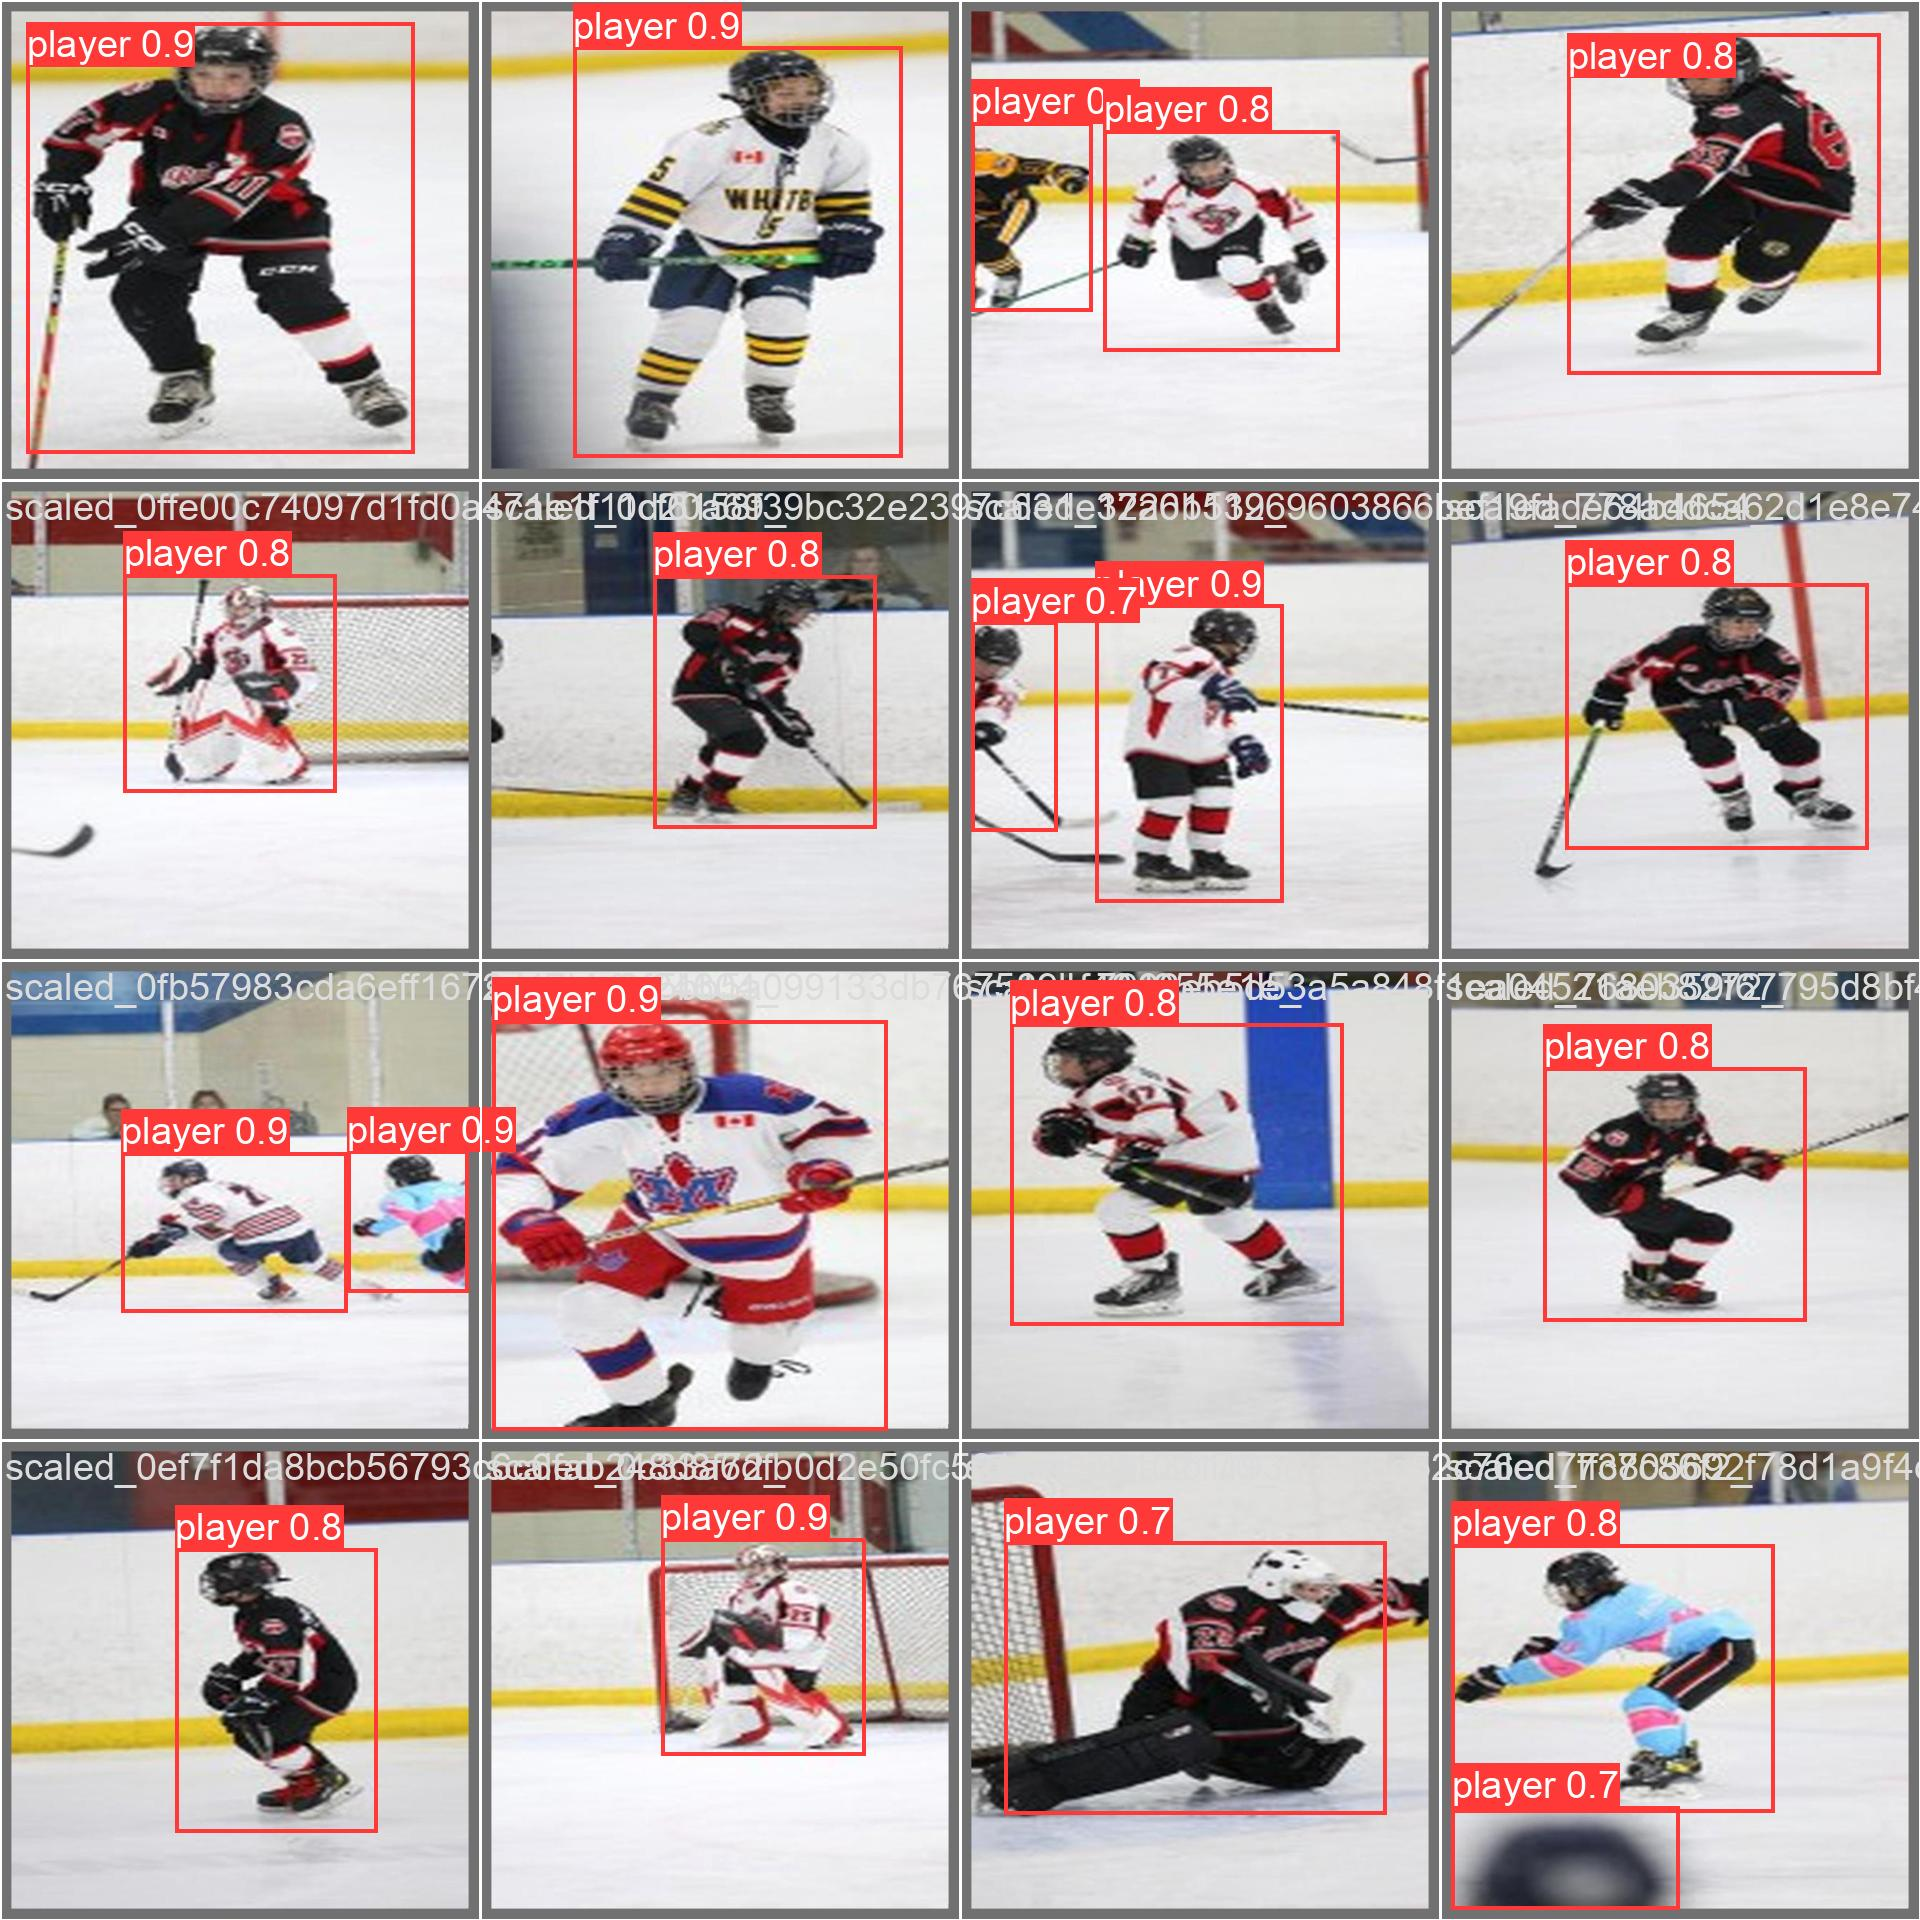

In [9]:
Image('/content/runs/detect/train/val_batch2_pred.jpg')

In [12]:
metrics = model.val()

Ultralytics YOLOv8.0.28 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126745 parameters, 0 gradients, 28.4 GFLOPs
val: Scanning /content/datasets/hockey-1/valid/labels.cache... 99 images, 0 backgrounds, 0 corrupt: 100%|██████████| 99/99 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/7 [00:00<?, ?it/s]os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]
                   all         99        176      0.695      0.822      0.855       0.51
                player         99        165      0.913      0.894      0.946      0.649
                  puck         99          9      0.836       0.57      0.622      0.161
                   ref 

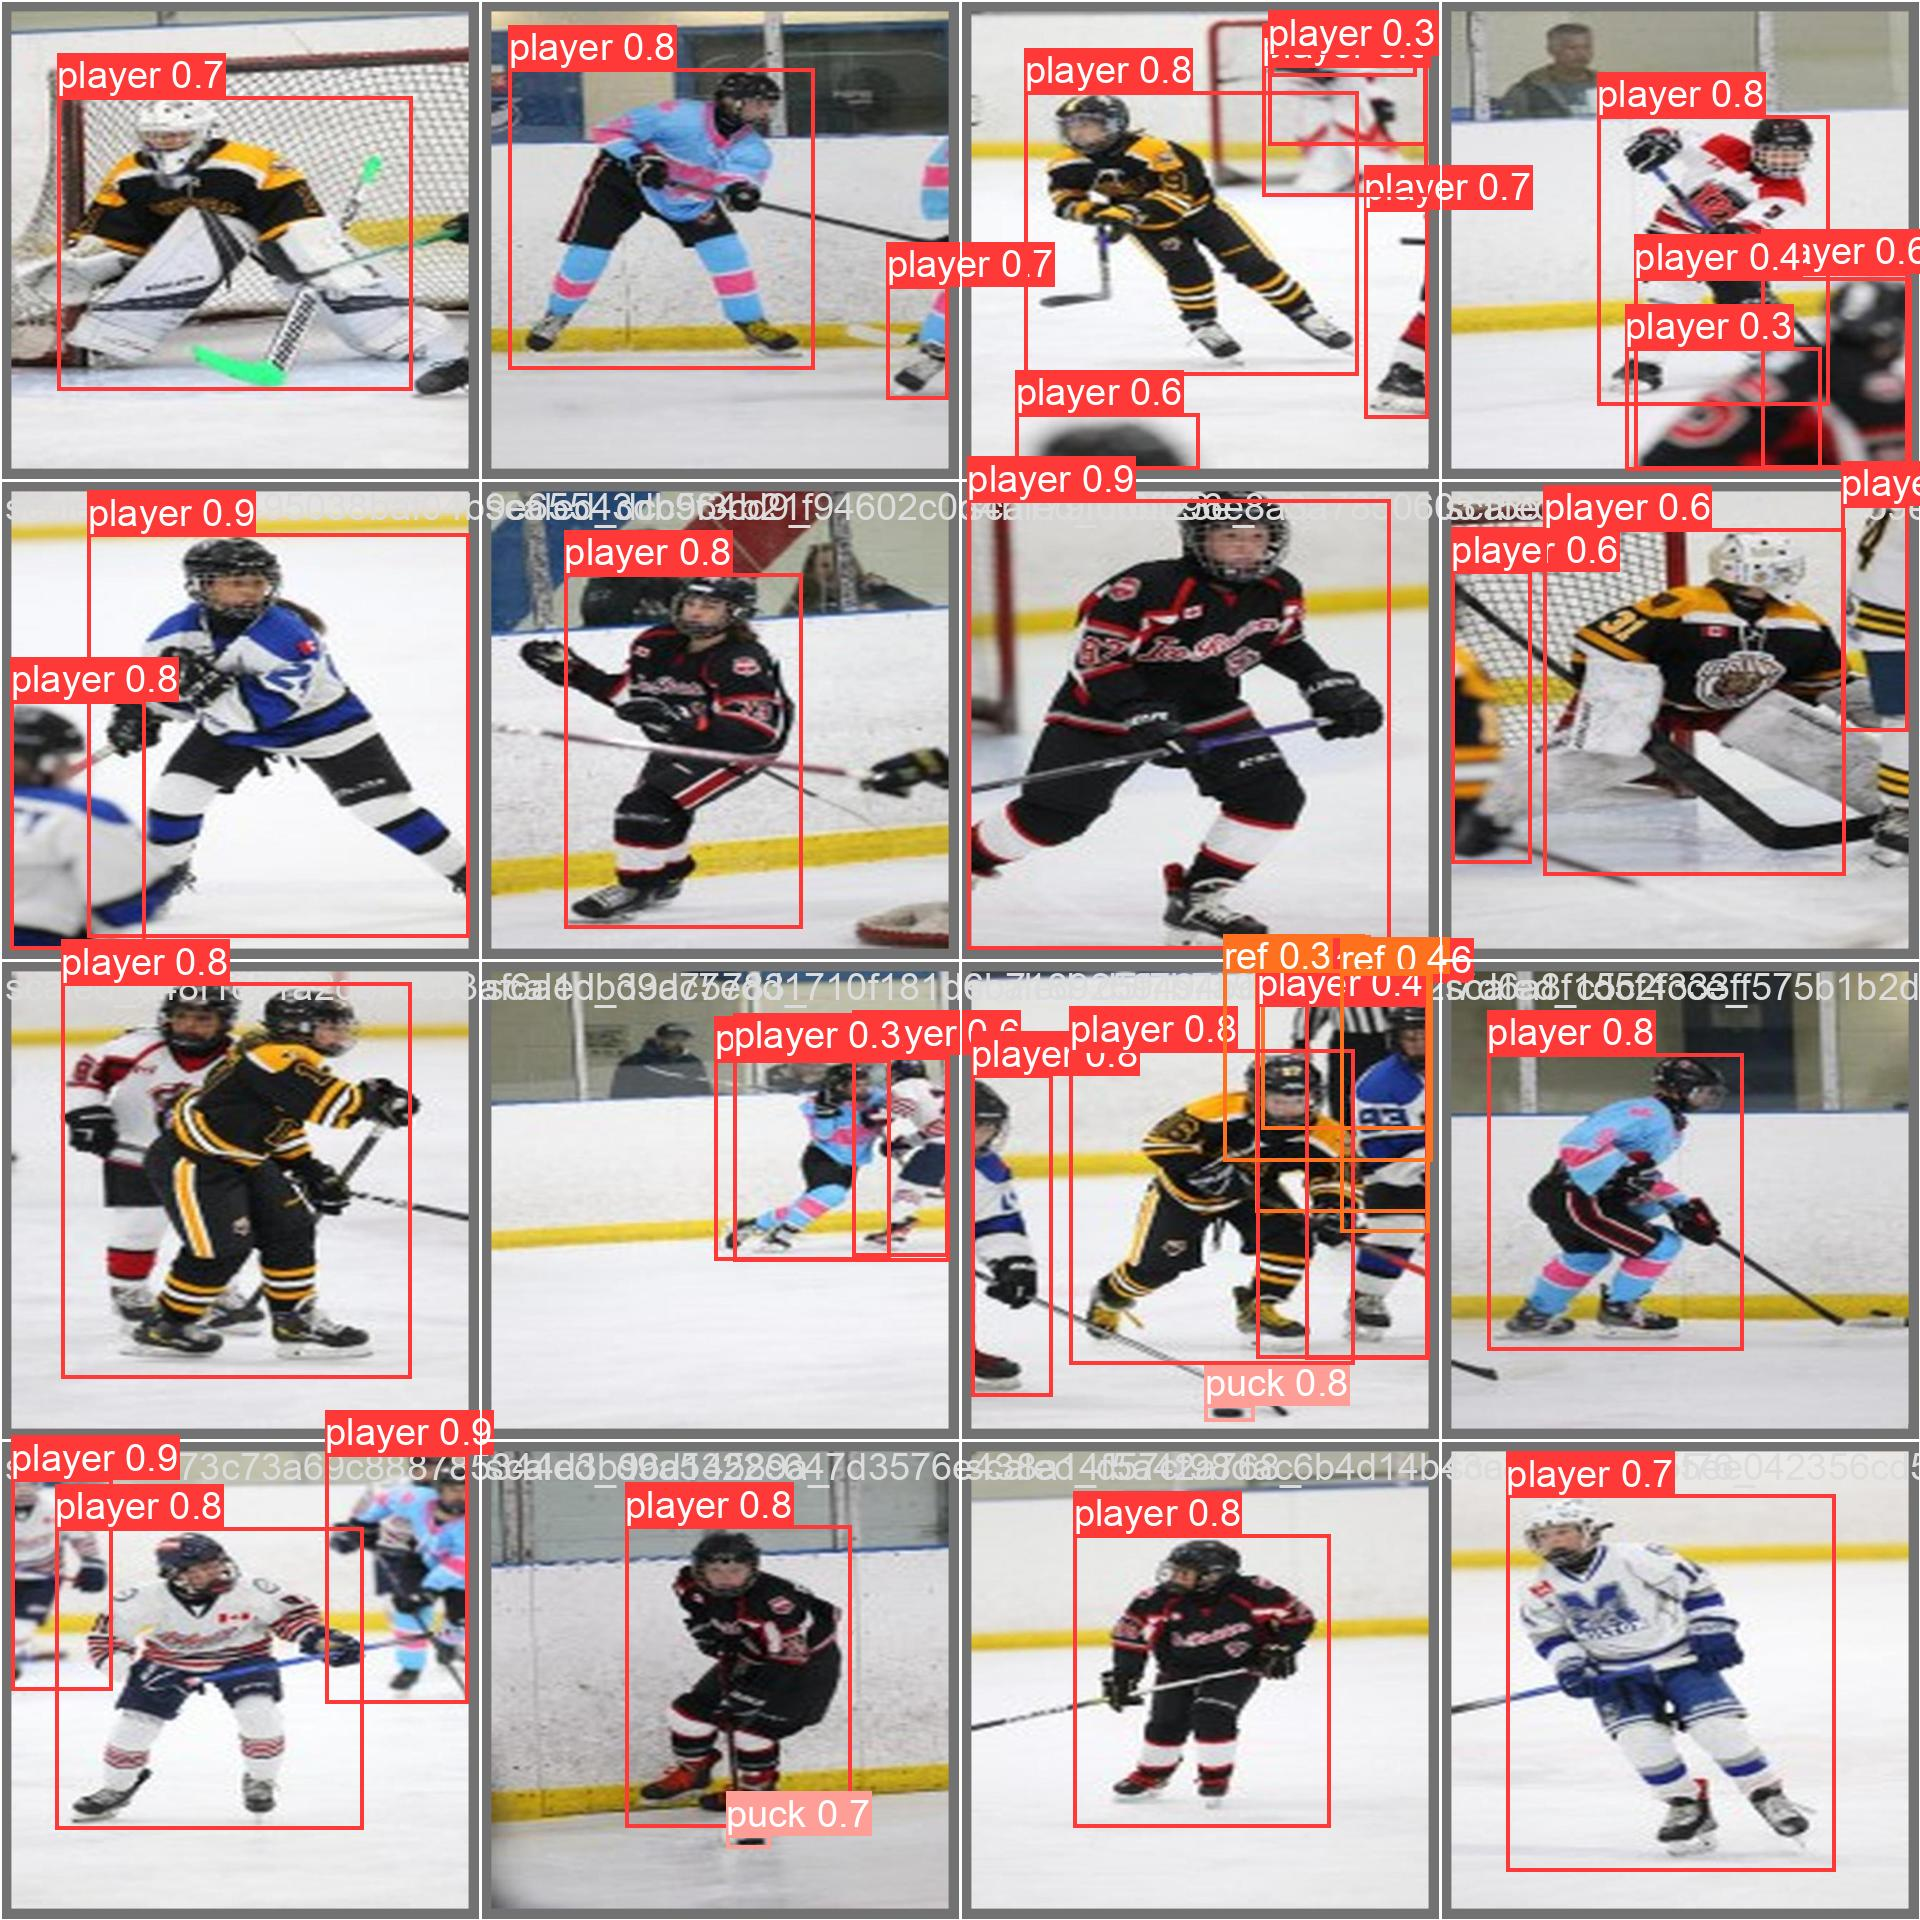

In [14]:
Image('/content/runs/detect/val/val_batch2_pred.jpg')

По предсказаниям на валидационной выборке в основном классы определяются верно. Однако бывают ошибки, такие как принятие нескольких объектов одного класса за один объект (решается проблема увеличением порога уверенности принадлежности к классу) и выявление нескольких bounding box, вместо одного на один объект, т.е. противоположная первой ошибка (решается так же как и первая).

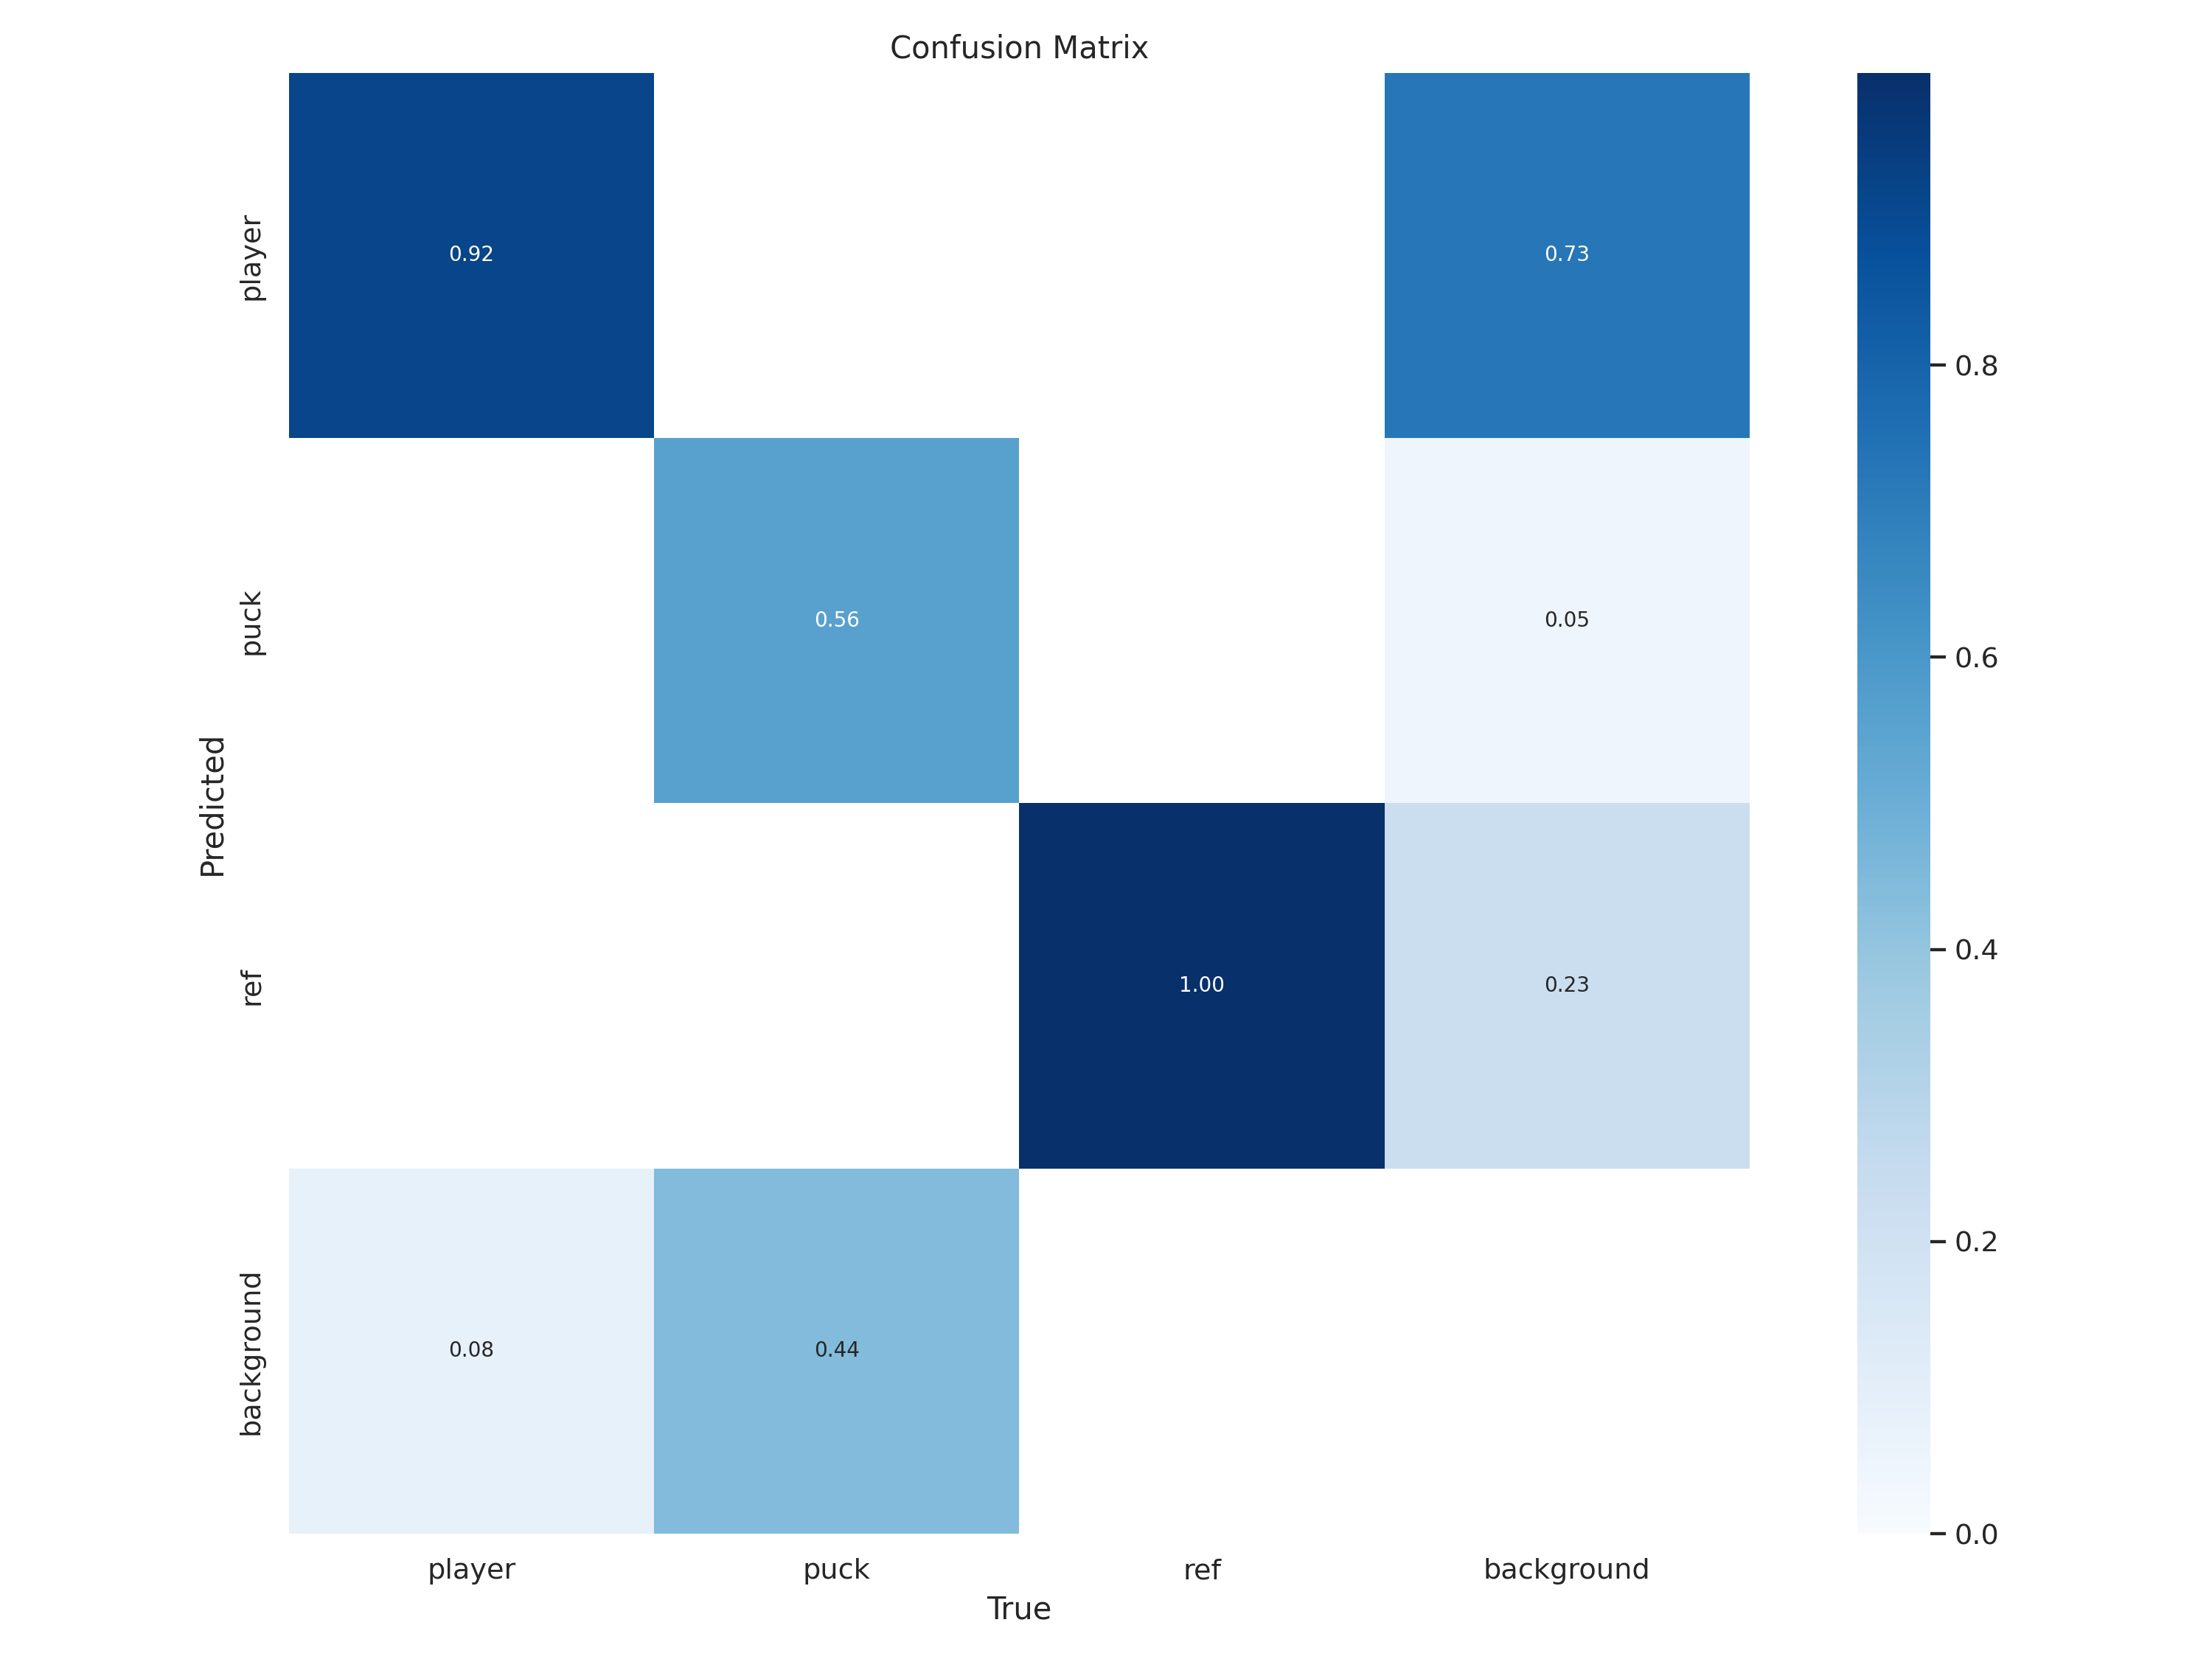

In [13]:
Image('/content/runs/detect/val/confusion_matrix.png')

По матрице ошибок видно, что чаще всего модель принимает задний фон за игроков и иногда шайбы за него же, что предсказуемо, ведь на заднем фоне могут быть люди, которых можно спутать с игроками, а что касается шайбы -их форма очень простая, т.к. по сути это просто черная точка, каких может быть немало на заднем плане. Однако в целом модель показывает неплохие результаты, для такого малого количество данных для обучения, которое, кроме того, было недолговременным (всего 30 эпох).

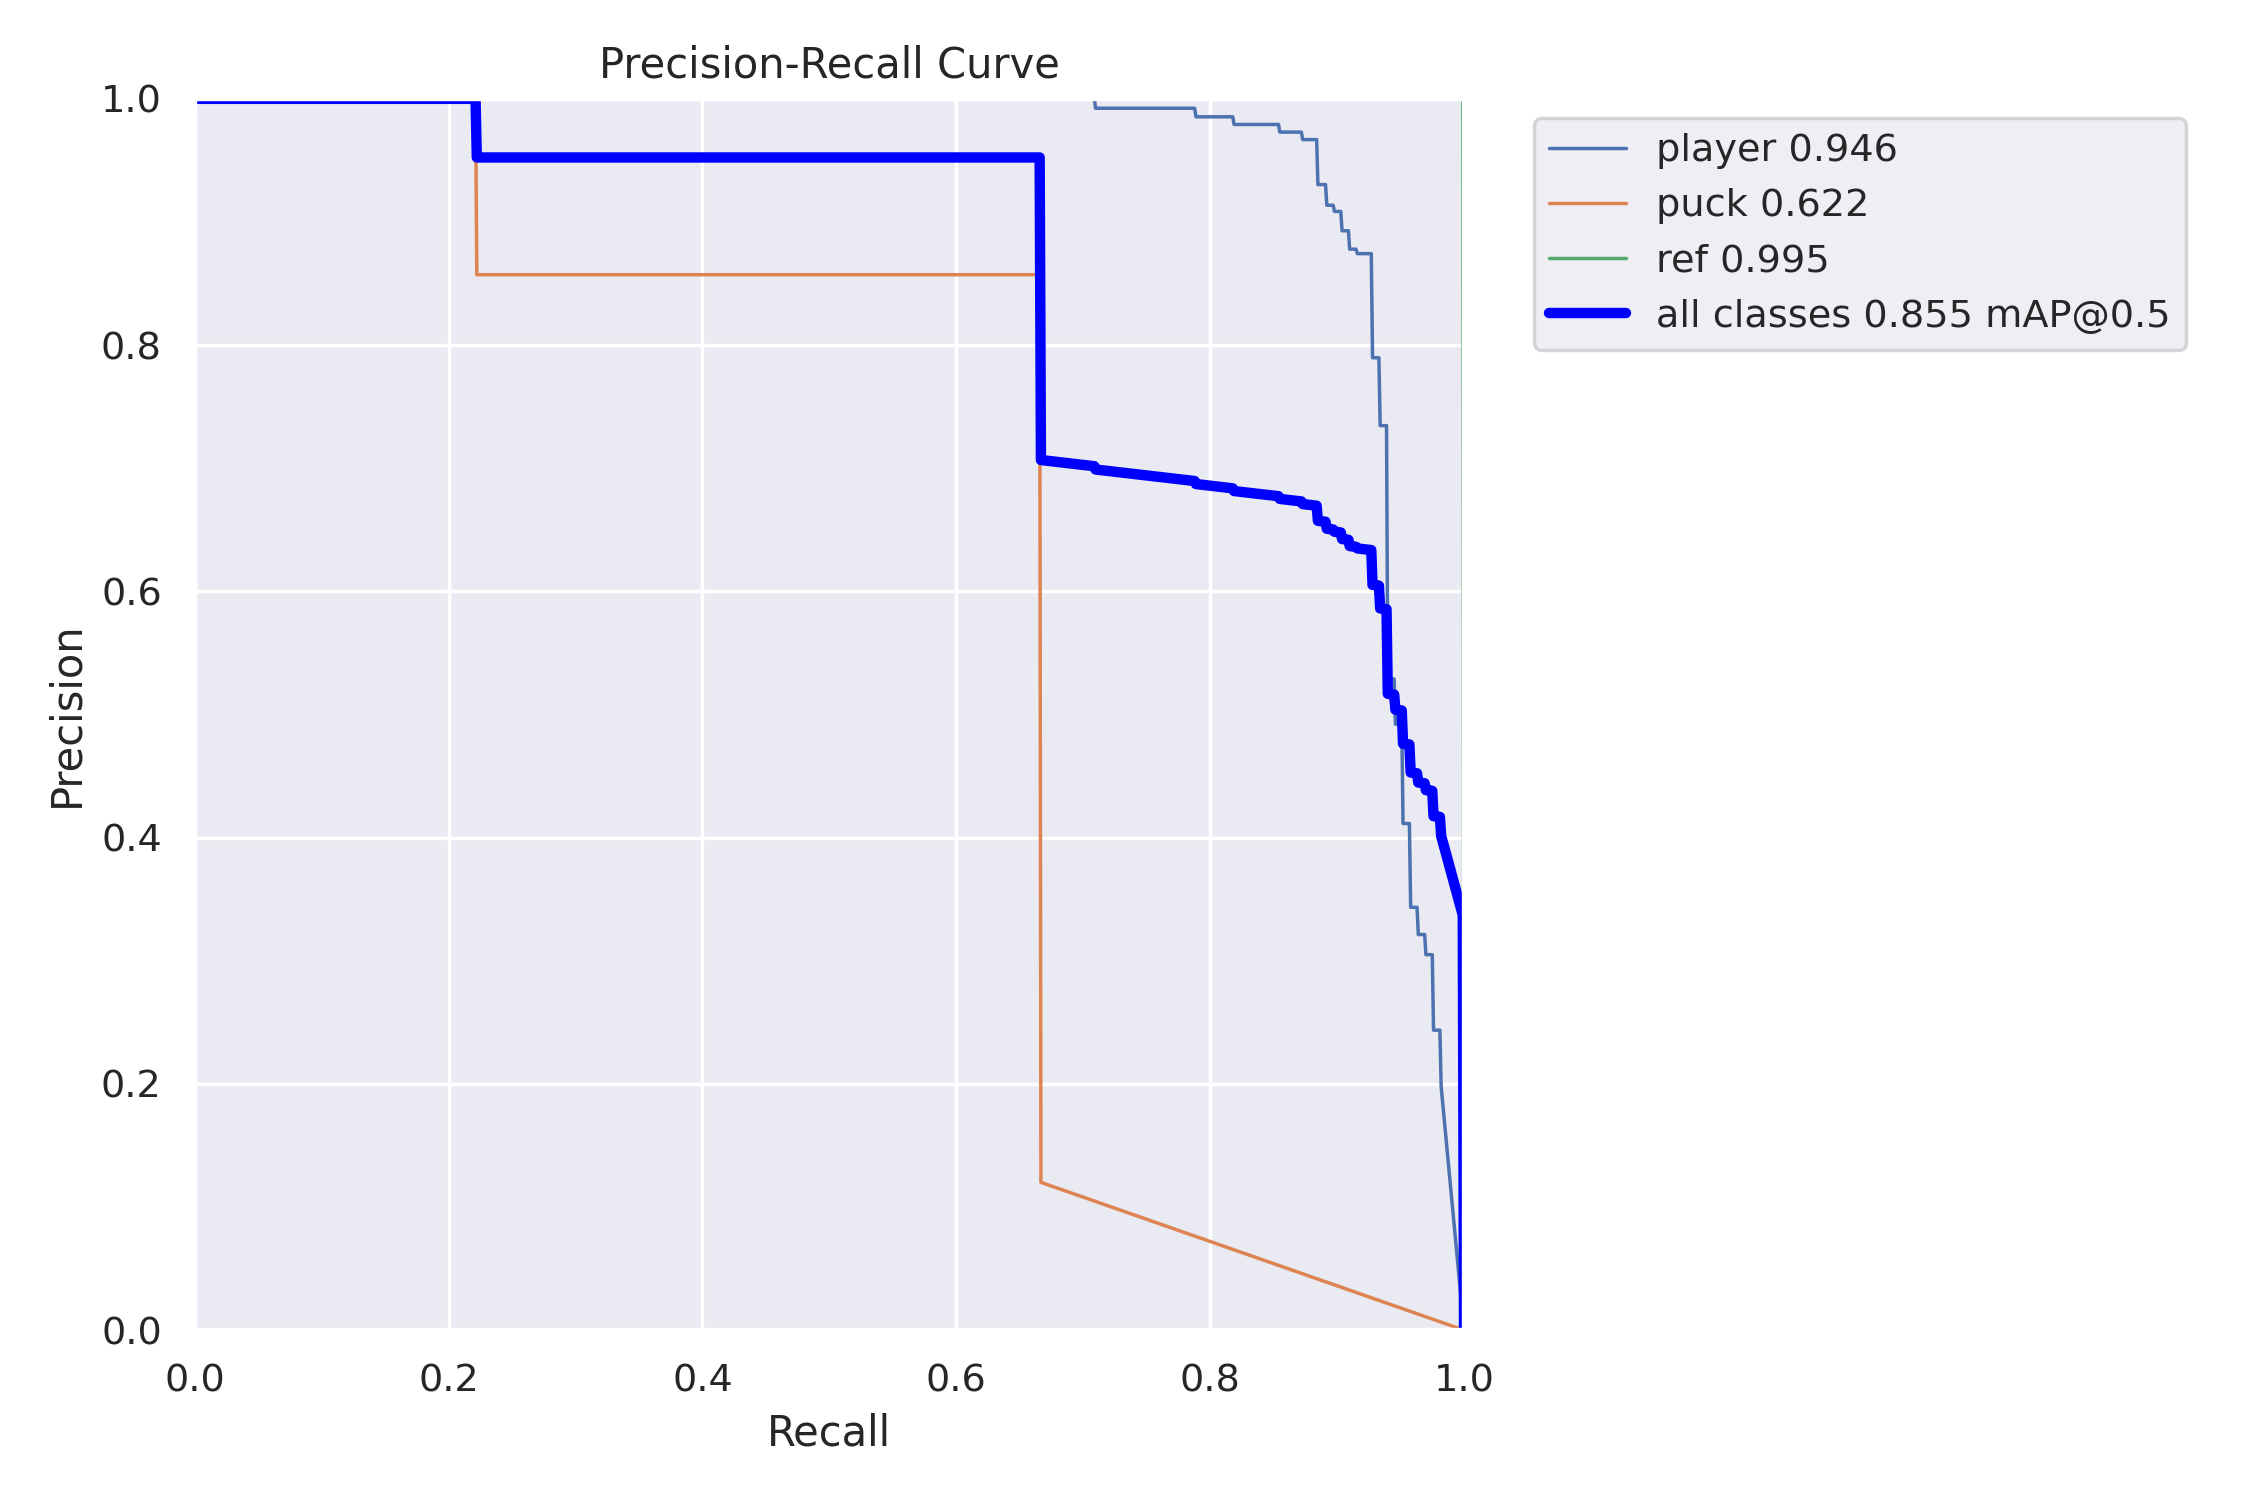

In [16]:
Image('/content/runs/detect/val/PR_curve.png')

Опять же видно, что область под PR графиком близка по площади к единице, что хорошо

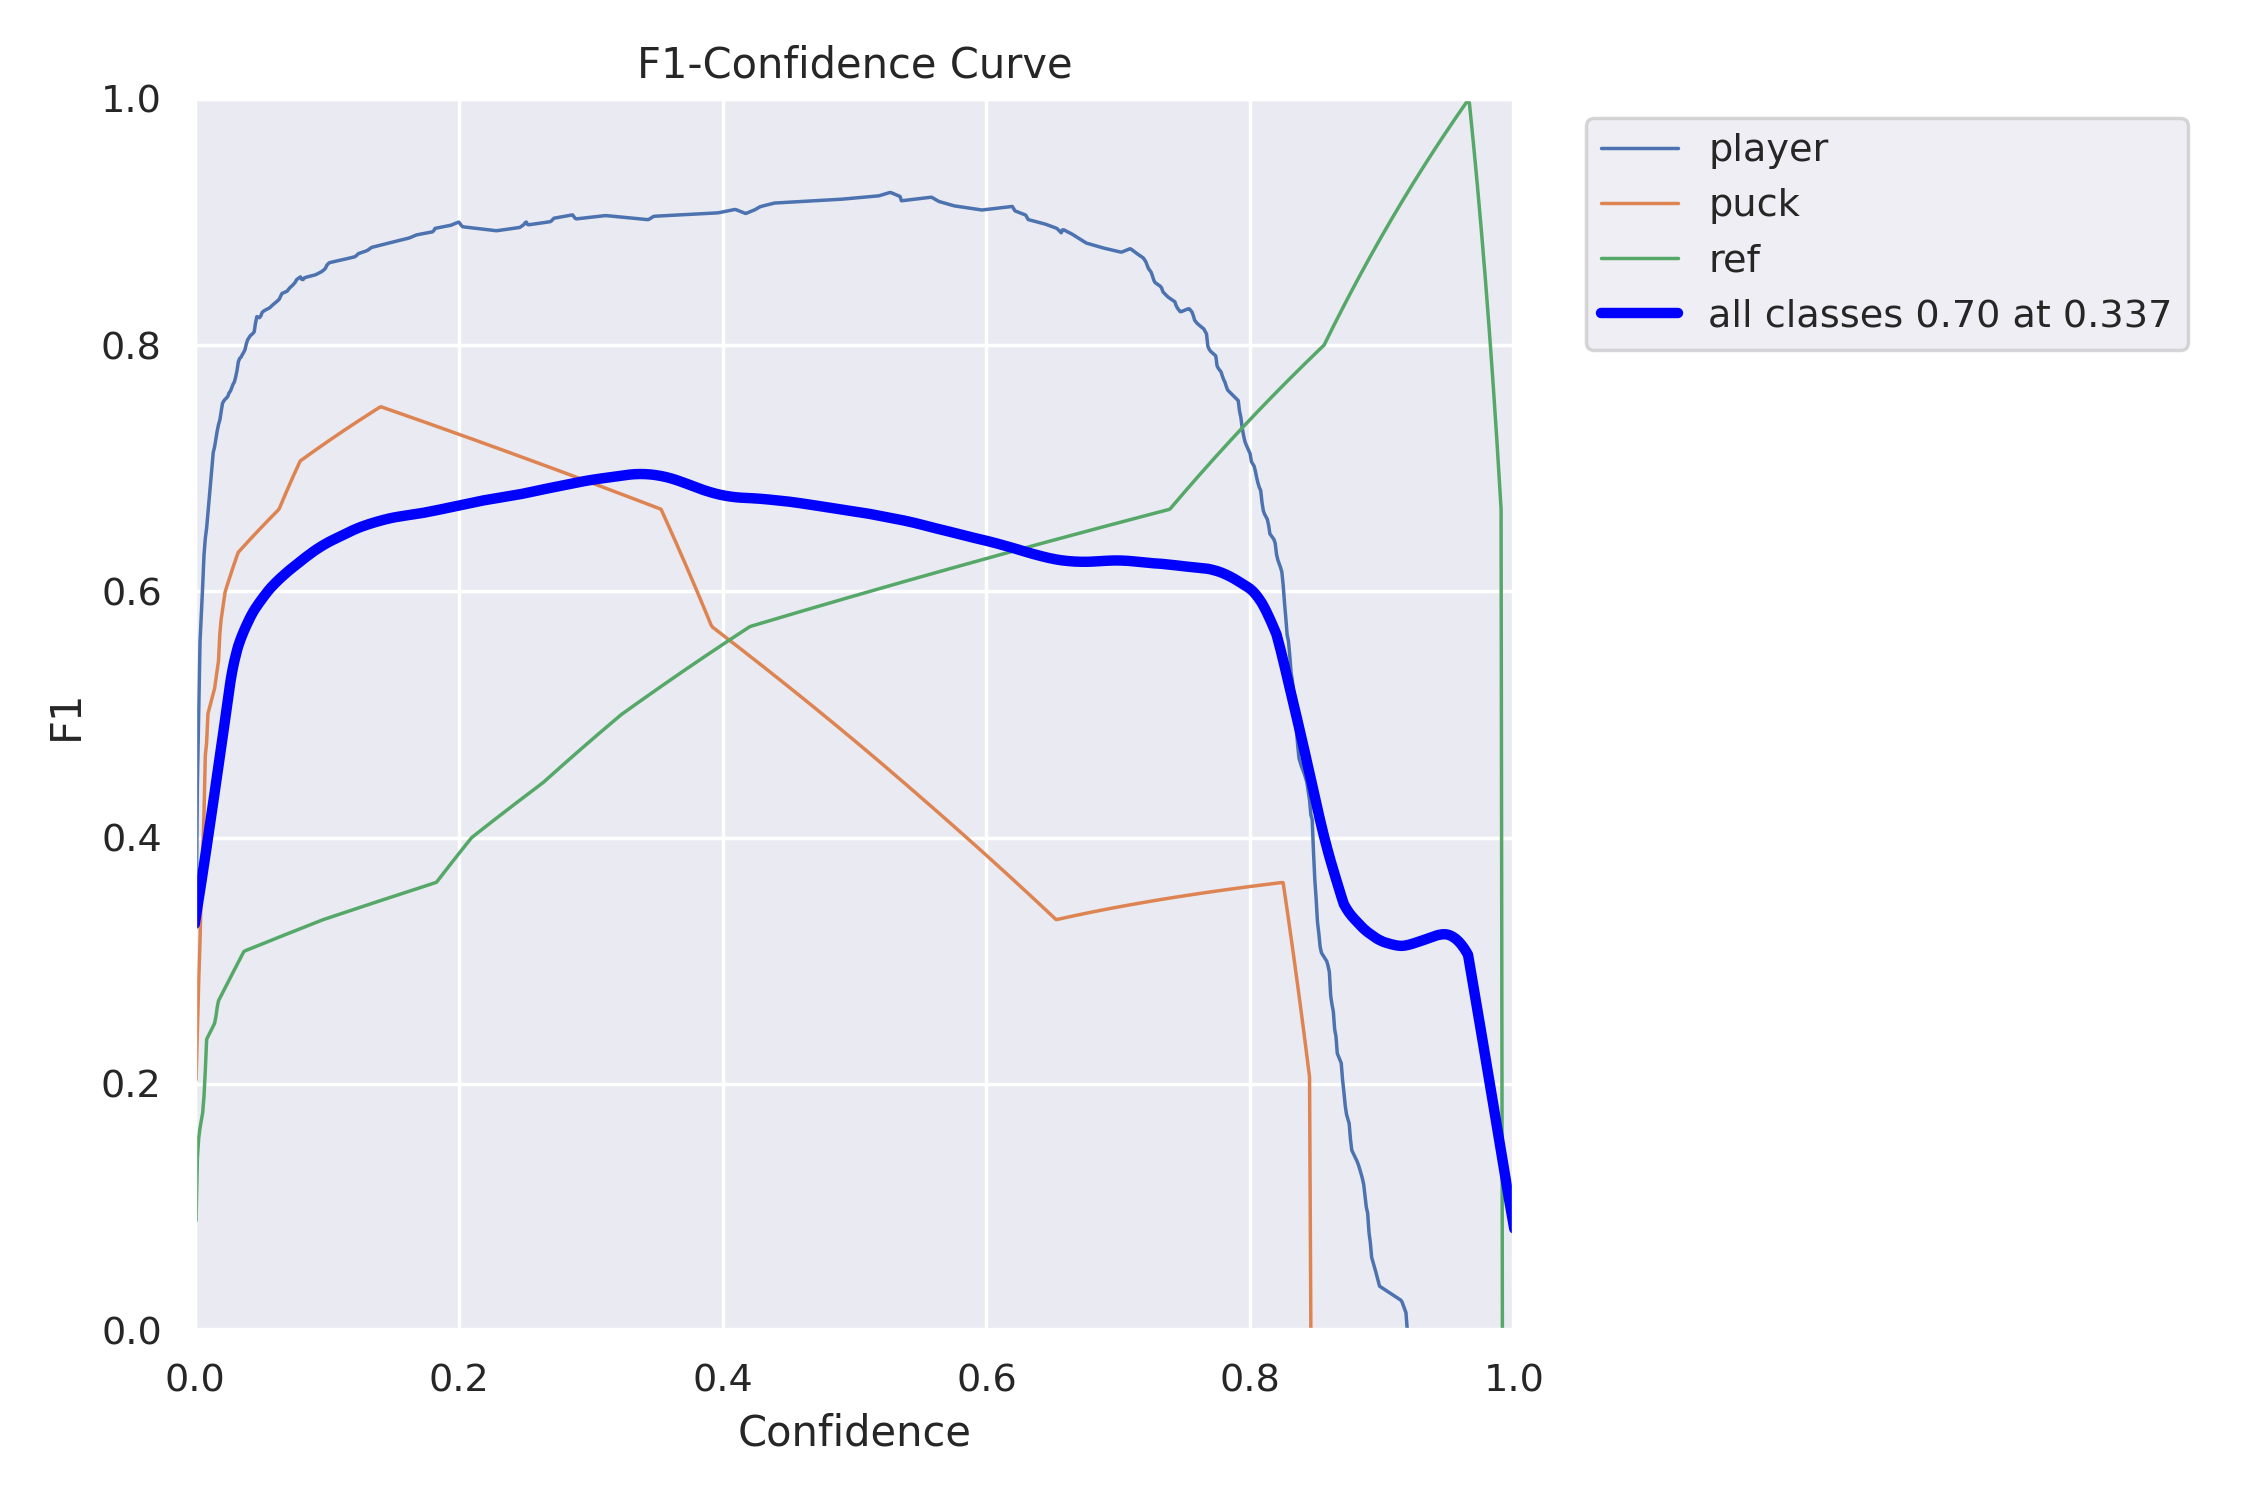

In [17]:
Image('/content/runs/detect/val/F1_curve.png')

F1 график несколько хуже по показателям PR графика. Видно, что лучше всего модель определяет игроков (но их в премерах и банально больше)

In [19]:
model.predict('/content/12.png', save=True, imgsz=640, conf=0.05,
              hide_labels=True)


image 1/1 /content/12.png: 384x640 14 players, 72.7ms
Speed: 0.5ms pre-process, 72.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


[Ultralytics YOLO <class 'ultralytics.yolo.engine.results.Boxes'> masks
 type: <class 'torch.Tensor'>
 shape: torch.Size([14, 6])
 dtype: torch.float32
  + tensor([[3.75000e+02, 1.35000e+02, 4.90000e+02, 3.91000e+02, 7.64568e-01, 0.00000e+00],
         [2.94000e+02, 1.01000e+02, 4.07000e+02, 2.41000e+02, 7.19530e-01, 0.00000e+00],
         [6.11000e+02, 2.37000e+02, 7.35000e+02, 4.07000e+02, 6.57450e-01, 0.00000e+00],
         [3.30000e+02, 1.29000e+02, 4.85000e+02, 3.92000e+02, 4.67836e-01, 0.00000e+00],
         [6.30000e+01, 1.06000e+02, 2.24000e+02, 2.26000e+02, 3.81963e-01, 0.00000e+00],
         [5.70000e+01, 3.30000e+01, 2.21000e+02, 2.25000e+02, 2.53826e-01, 0.00000e+00],
         [2.08000e+02, 1.86000e+02, 2.97000e+02, 2.84000e+02, 1.65395e-01, 0.00000e+00],
         [2.43000e+02, 1.76000e+02, 3.00000e+02, 2.82000e+02, 1.40445e-01, 0.00000e+00],
         [5.20000e+01, 3.60000e+01, 1.79000e+02, 1.74000e+02, 1.15505e-01, 0.00000e+00],
         [2.55000e+02, 1.78000e+02, 3.09000e

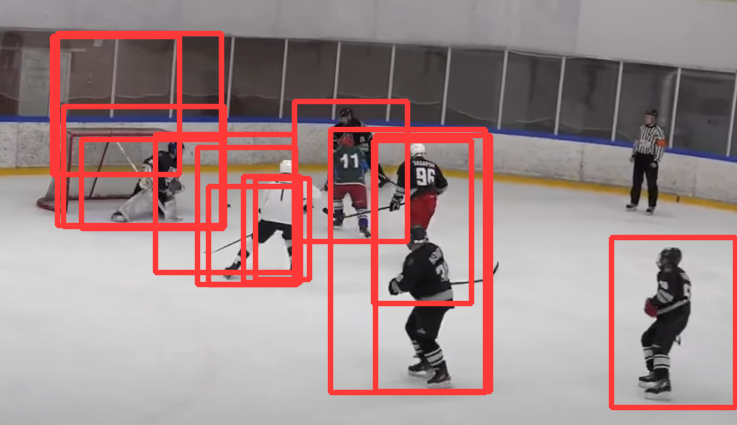

In [20]:
Image('/content/runs/detect/predict/12.png')

Что же, на реальном примере результаты, конечно, неутешительные. Рефери модель не нашла вообще, а на игроков навешала кучу лишних баундинг боксов. Однако какие-то результаты модель выдает, хоть и не абсолютные, но есть куда расти. Надо дообучить модель и поднастроить параметры